In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

#setup y
y_cols = ['Ever Enrolled Count']


    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.std()

In [3]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=test_size)

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse Ever Enrolled Count    2.822326e+07
dtype: float64


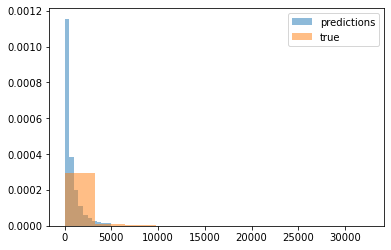

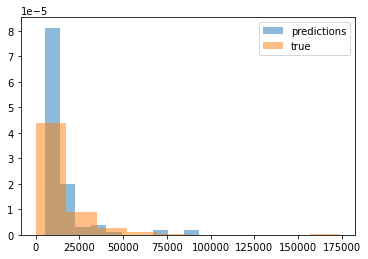

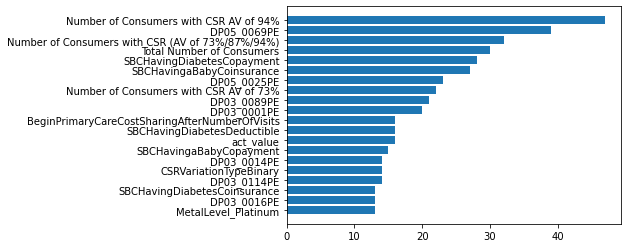

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
FL     34701.136719         32711.777778  35529.595539  53767.251431
TX     26814.054688         33706.222222  26959.855262  30245.040915
PA     17911.029297         29047.000000           NaN           NaN
MO     17742.039062          6116.000000           NaN           NaN
NC     16907.417969         27125.000000   2341.976329  29817.278749
IL     15413.919922          2499.500000   5395.580365   2839.033726
AZ     15287.740234         14858.500000  21620.129577   6269.915829
TN     14252.839844         13013.500000   6391.038249  16801.564228
AL     14166.975586          7156.000000           NaN           NaN
LA     13833.214844          4222.500000   3382.358971   5558.566407
VA     12848.994141         32449.000000           NaN           NaN
SC     12532.583984          1478.000000    235.783513     93.338095
NV     11119.860352         47446.

In [5]:
# not super deep, but uses most of the data at one
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=2, eta=.5, subsample=0.9, colsample_bytree=.9)
model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
print( 'mse', ((y_test - y_pred)**2).mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

mse Ever Enrolled Count    2.901123e+07
dtype: float64


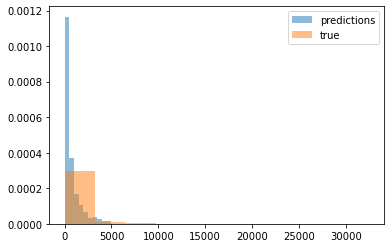

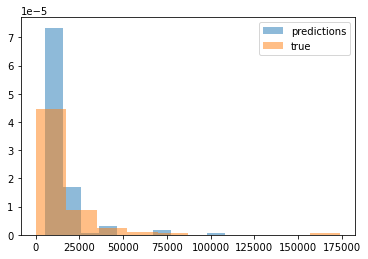

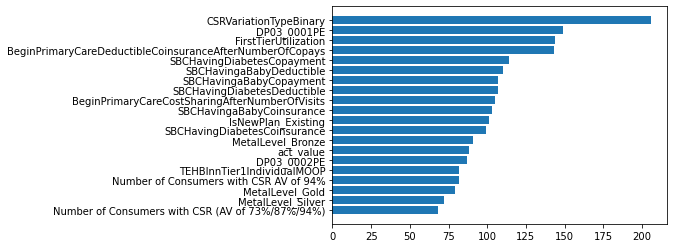

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
PA     38664.296875          5351.000000           NaN           NaN
FL     29094.326172         35416.909091  32893.642873  47658.390016
MO     19814.234375          8214.333333   2579.567800   1840.283221
TX     17961.619141         21753.083333  12497.697370  26265.071142
GA     17138.792969         20266.500000   3953.261380  14213.553409
SC     17036.578125          1478.000000   2558.879953     93.338095
IL     15169.935547          2499.500000    843.670231   2839.033726
NV     13240.511719         47446.000000           NaN           NaN
TN     12810.081055         11694.333333   5875.136776  12098.218147
NC     12280.708984         22591.666667   6095.283898  22498.630832
MI      9497.834961          1470.000000           NaN           NaN
UT      9443.771484         24061.333333   6871.584834   9691.296215
AZ      5655.043945         19292.

In [6]:
#uses much less data, the covariates seem more accurate...
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=5, eta=.5, subsample=0.5, colsample_bytree=.9)
model.fit(X_train, y_train)

model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
print( 'mse', ((y_test - y_pred)**2).mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

alpha_value: 100 mse Ever Enrolled Count    2.584808e+07
dtype: float64


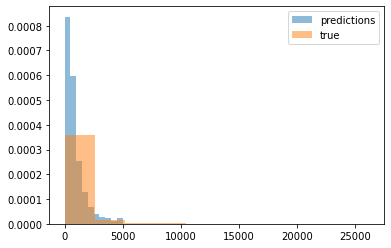

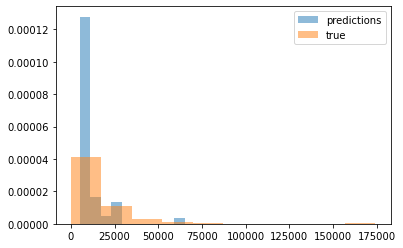

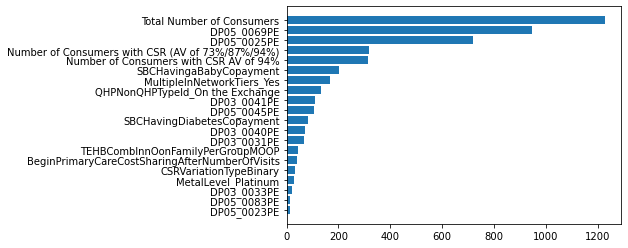

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
FL     23091.517395         30320.357143  19851.026466  43209.159667
TX     16865.349005         36059.888889   8820.710765  27778.894324
IL     12667.164858         10896.500000  12419.790525   9036.117557
NV     10333.828144         47446.000000           NaN           NaN
GA      9008.658060         12911.250000   1028.280528  14424.657324
MO      7175.895626         22955.000000           NaN           NaN
NC      6789.925228         25811.500000   2712.849636  15332.963804
VA      6375.172463         22863.500000   3949.587989  13555.944102
PA      6111.634605         23090.000000   1140.183864   8424.470191
TN      5094.555780         24894.000000           NaN           NaN
MI      4671.619352         14810.500000   3526.210288   6456.592019
UT      4347.793818         22802.000000   2229.584886   8304.085139
KS      4345.217508         16919.

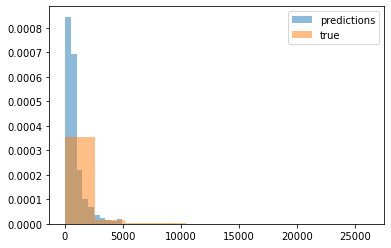

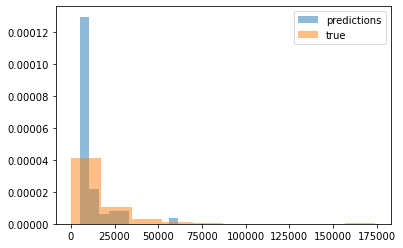

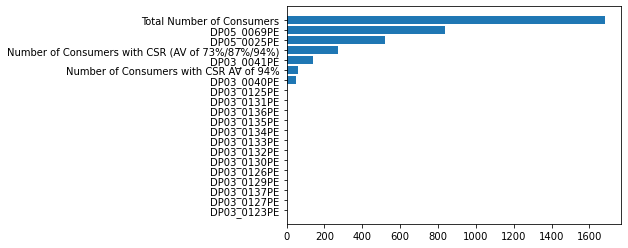

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
FL     22116.238270         30320.357143  19075.736358  43209.159667
TX     16381.397868         36059.888889   8851.713928  27778.894324
IL     12413.483365         10896.500000  12274.555118   9036.117557
NV      9281.482266         47446.000000           NaN           NaN
GA      8495.637072         16705.666667    778.215357  15023.998181
MO      7034.025533         22955.000000           NaN           NaN
NC      6670.412676         25811.500000   2787.850240  15332.963804
VA      5932.147570         22863.500000   3967.601875  13555.944102
TN      5124.157532         24894.000000           NaN           NaN
MI      4633.740259         14810.500000   3512.995113   6456.592019
PA      4499.816281         23090.000000   1195.650017   8424.470191
UT      4472.136227         22802.000000   2233.394903   8304.085139
OH      4254.363773         12910.

In [7]:
# Vary alpha values
a = [100,250]#[50,100,150,200,250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,X_test)
    
    print('alpha_value:', i, 'mse', ((y_test - y_pred)**2).mean()) 
    
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(report_error(y_test,y_pred))
    print('==========================================')
    print('==========================================')

In [8]:
#some training sets total number of consumers?
#some times DP03_CSR?